# Galaxies: An interactive graduate course

## Chapter 4: The formation of dark matter halos

#### (c) Benedikt Diemer, University of Maryland

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### 4.1) Non-linear growth and halo collapse

The top-hat collapse model tells us that overdensities decouple from the Hubble flow and collapse at $\delta_{\rm c} = 1.686$. This means that at each redshift, there is a characteristic scale $R$ where the AVERAGE variance within spheres, $\sigma(R)$, reaches $\delta_{\rm c}$. We can take that scale as a proxy for the perturbations that are typically collapsing at a certain time. This scale $R$ tells us the mass enclosed, namely the Lagrangian mass of the halos that form. In other words, the non-linear mass for which typical perturbations are reaching the critical threshold is defined via $\sigma(R_{\rm L}[M], z) = \delta_{\rm c}$. Colossus can execute this calculation. Let's find the typical non-linear mass today.

In [2]:
from colossus.lss import peaks

M_nl_today = peaks.nonLinearMass(0.0) / cmn.cosmo.h
print('The typical collapsing mass today is %.1e Msun.' % M_nl_today)

The typical collapsing mass today is 6.2e+12 Msun.


Let's now plot the evolution of the non-linear mass, as well as other peak heights (since the non-linear mass corresponds to $\nu = 1$).

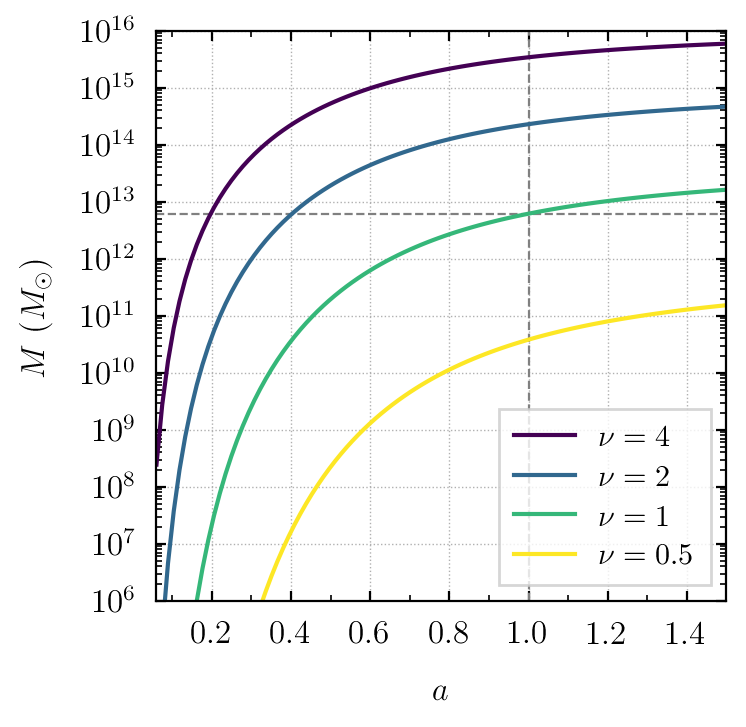

In [3]:
from matplotlib.ticker import LogLocator, MultipleLocator

peak_heights = [4, 2, 1, 0.5]
cmap = plt.get_cmap('viridis')

a = np.linspace(0.06, 1.5, 100)
z = 1.0 / a - 1.0

plt.figure(figsize = (3.8, 3.8))
ax = plt.gca()
plt.yscale('log')
plt.xlabel(r'$a$')
plt.ylabel(r'$M\ (M_\odot)$')
plt.xlim(a[0], a[-1])
plt.ylim(1E6, 1E16)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(LogLocator(numticks = 100))
ax.yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.grid(lw = 0.5, ls = ':')

plt.axhline(M_nl_today, ls = '--', color = 'gray', lw = 0.8)
plt.axvline(1.0, ls = '--', color = 'gray', lw = 0.8)

for i in range(len(peak_heights)):
    nu = peak_heights[i]
    M = peaks.massFromPeakHeight(nu, z) / cmn.cosmo.h
    plt.plot(a, M, color = cmap(float(i) / (len(peak_heights) - 1.0)), label = r'$\nu = %s$' % (str(nu)))

plt.legend(frameon = True)
plt.show()

This is why structure formation occurs bottom-up: small things collapse first because the variance of the density field is much higher on small scales!

### 4.2) The halo mass function

#### The Press-Schechter formalism

Let's first plot the multiplicity function, the universal distribution of peak heights:

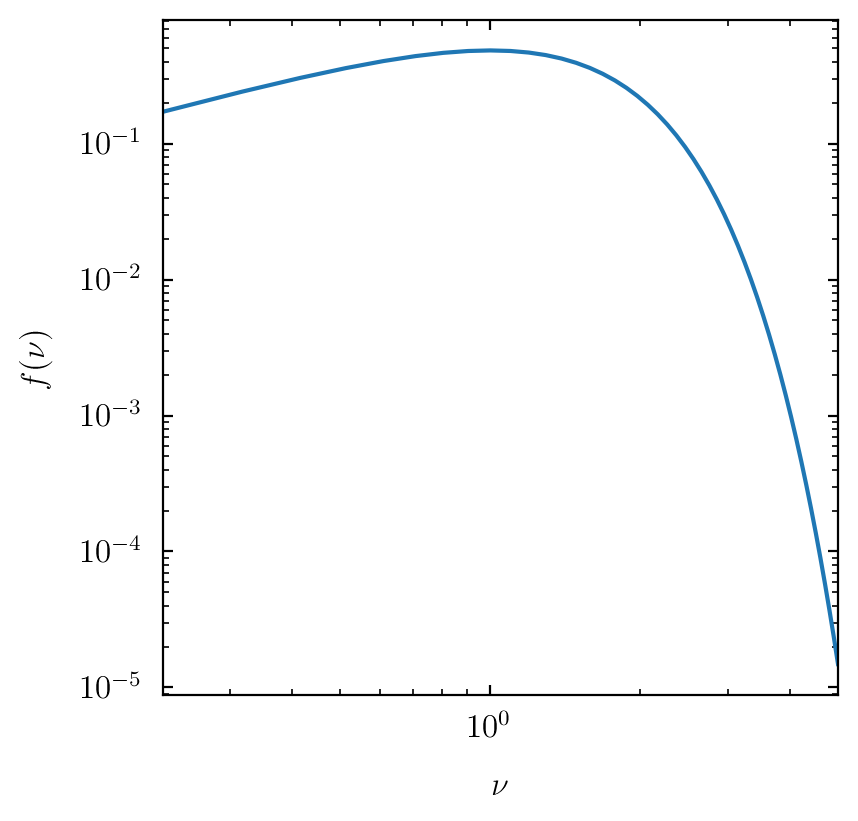

In [4]:
nu = np.linspace(0.22, 5.0, 50)
f_PS = np.sqrt(2.0 / np.pi) * nu * np.exp(-nu**2 / 2.0)

plt.figure()
plt.loglog()
plt.xlim(nu[0], nu[-1])
plt.xlabel(r'$\nu$')
plt.ylabel(r'$f(\nu)$')
plt.plot(nu, f_PS)
plt.show()

The peak height space is not always the most intuitive. Let's translate this into masses using Colossus, which has a whole module dedicated to the mass function. We plot multiple redshifts to see how the mass function evolves with time.

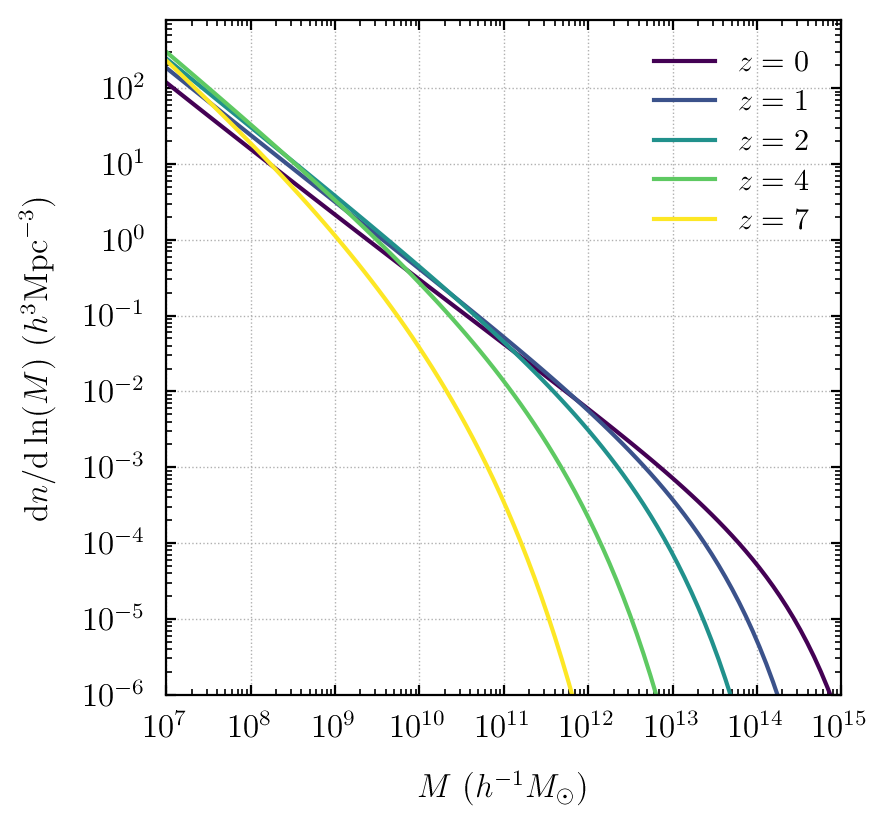

In [5]:
from colossus.lss import mass_function

zs = [0, 1, 2, 4, 7]

cosmo = cmn.cosmo
M = 10**np.linspace(7.0, 15.0, 100)

plt.figure()
plt.loglog()
plt.xlim(M[0], M[-1])
plt.ylim(1E-6, 8E2)
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.xlabel(r'$M\ (h^{-1} M_\odot)$')
plt.ylabel(r'${\rm d}n / {\rm d} \ln(M)\ (h^3 {\rm Mpc}^{-3})$')
plt.grid(lw = 0.5, ls = ':')

for i in range(len(zs)):
    c = cmap(float(i) / (len(zs) - 1.0))
    dn_dlnM_col = mass_function.massFunction(M, zs[i], q_in = 'M', q_out = 'dndlnM', model = 'press74')
    plt.plot(M, dn_dlnM_col, c = c, label = r'$z = %s$' % str(zs[i]))

plt.legend()
plt.show()

As expected, the mass function grows with time, but at the low-mass end it can decrease with time at a fixed mass because of the different relative growth of different masses.

#### Understanding the Press-Schechter procedure

We can understand the Press-Schechter model better by applying it to a weird power spectrum and considering the intermediate steps. We begin by defining two power spectra: our fiducial LCDM one, and an artificial one with a single peak.

In [6]:
n_ps = 2

def powerSpectrumPeak(k):

    peak_log_k = 0.2
    peak_sigma2 = 0.2
    peak_norm = 200.0
    
    log_k = np.log10(k)
    g = peak_norm * np.exp(-0.5 * ((log_k - peak_log_k) / peak_sigma2)**2) / (peak_sigma2 * np.sqrt(2.0 * np.pi))
    
    return g

def getPkFunc(idx):

    if idx == 0:
        func = cmn.cosmo.matterPowerSpectrum
        label = r'$\mathrm{Planck\ 2018}$' 
    elif idx == 1:
        func = powerSpectrumPeak
        label = r'$\mathrm{Single\ peak}$' 
    
    return func, label

The first step is to normalize the single-peak power spectrum to the same $\sigma_8$ as our $\Lambda$CDM one. Otherwise, all kinds of quantities will come out differently because of the normalization.

In [7]:
import scipy
from routines import theory

def sigmaIntegrandLog(k, R, Pk_func):
    
    k = np.exp(k)
    W = theory.filterFourierSpace(k * R)
    
    return k**3 * Pk_func(k) * np.abs(W)**2

def sigma(R, Pk_func):

    k_min = 1E-10
    k_max = 1E10
    sigma2, _ = scipy.integrate.quad(sigmaIntegrandLog, np.log(k_min), np.log(k_max), 
                                     args = (R, Pk_func), epsrel = 1E-3, epsabs = 1E-20)
    sigma2 /= 2.0 * np.pi**2
    sigma = np.sqrt(sigma2)
    
    return sigma

cosmo = cmn.cosmo
log_R_plot = np.linspace(-2.0, 2.0, 100) 
R_plot = 10**log_R_plot
sig = np.zeros((n_ps, len(R_plot)), float)
norm_factors = np.ones((2), float)

for i in range(n_ps):

    # Compute sigma(R)
    pk_func, _ = getPkFunc(i)
    for j in range(len(R_plot)):
        sig[i, j] = sigma(R_plot[j], pk_func)

    # Normalize to the correct sigma8 for the peak model
    if i == 1:
        sigma8_unnormed = sigma(8.0, pk_func)
        norm_factors[i] = cmn.cosmo.sigma8 / sigma8_unnormed
        print('sigma8 for peak power spectrum is %.2f, LCDM %.2f, normalizing by factor of %.2f.' \
              % (sigma8_unnormed, cmn.cosmo.sigma8, norm_factors[i]))
        sig[i] *= norm_factors[i]

sigma8 for peak power spectrum is 0.13, LCDM 0.81, normalizing by factor of 6.00.


/var/folders/qx/cvkzqsdj68n1yst_wxdz8dqr0000gn/T/ipykernel_15650/1374765197.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sigma2, _ = scipy.integrate.quad(sigmaIntegrandLog, np.log(k_min), np.log(k_max),


We can now plot the renormalized power spectra.

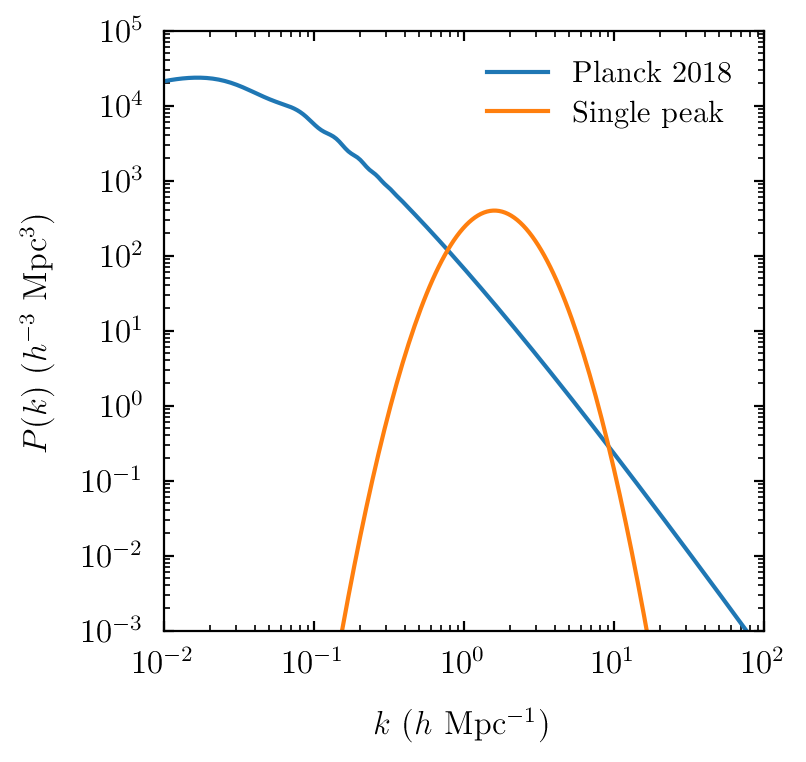

In [8]:
log_k_plot = np.linspace(-2.0, 2.0, 200)
k_plot = 10.0**log_k_plot

plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$k\ (h\rm\ Mpc^{-1})$')
plt.ylabel(r'$P(k)\ (h^{-3}\ \rm Mpc^3)$')
plt.xlim(1E-2, 1E2)
plt.ylim(1E-3, 1E5)
plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.gca().yaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i in range(n_ps):
    pk_func, label = getPkFunc(i)
    Pk_plot = pk_func(k_plot)
    plt.plot(k_plot, Pk_plot, label = label)

plt.legend()
plt.show()

Let's plot a density field with each spectrum to get a visual impression. We divide the single-peak density field by the root of the normalization factor, since $\delta \propto \sigma \propto \sqrt{P(k)}$.

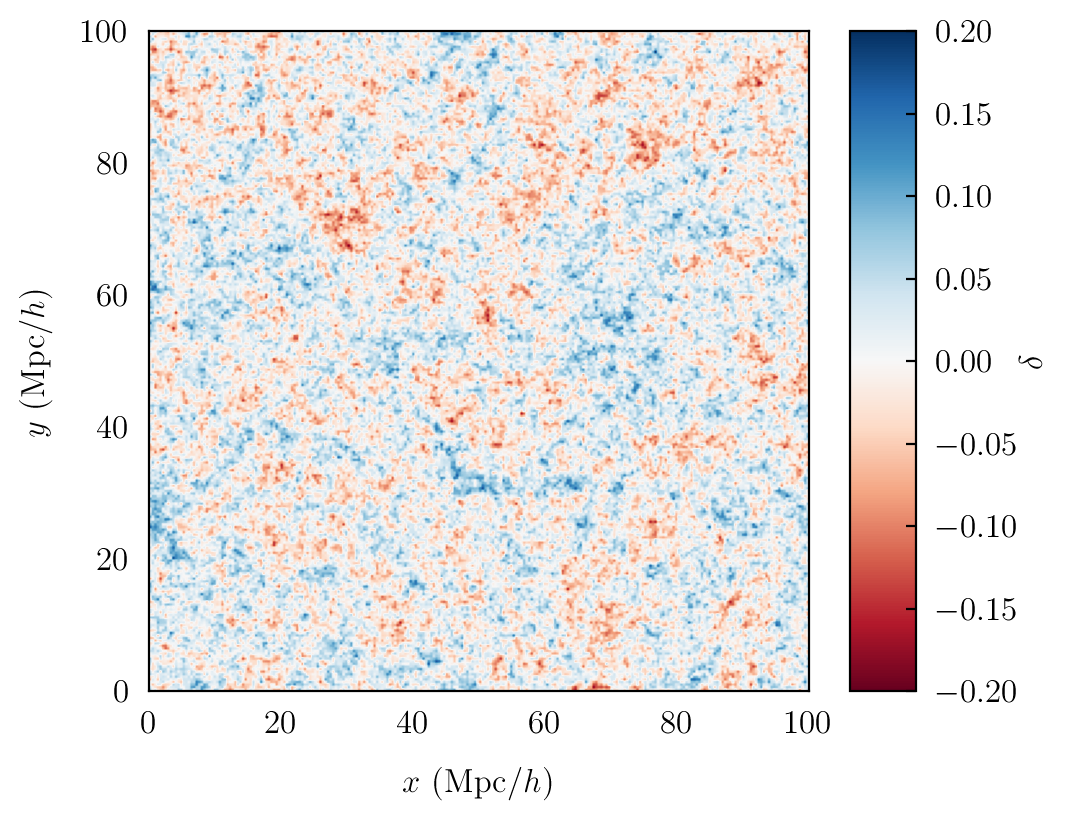

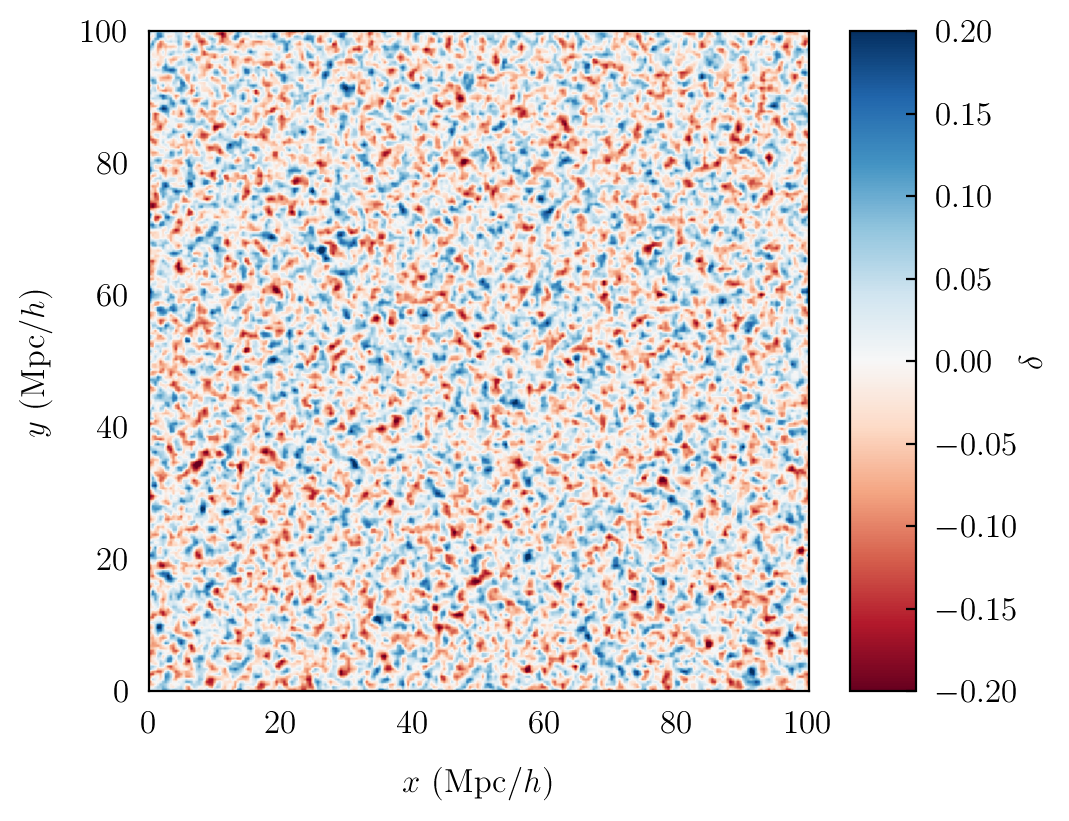

In [9]:
Lbox = 100.0
N = 256
z_ini = 30.0
np.random.seed(2024)

for i in range(n_ps):

    pk_func, _ = getPkFunc(i)
    k, delta, delta_k, D = theory.gaussianRandomField(Lbox, N, z_ini, pk_func)
    N_half = int(N / 2)
    delta_slice = delta[:, :, N_half]
    delta_slice /= np.sqrt(norm_factors[i])
    #max_ext = max(np.max(delta_slice), np.abs(np.min(delta_slice))) * 0.8
    max_ext = 0.2

    plt.figure(figsize = (5.5, 5.5))
    #plt.subplots_adjust(left = 0.13, right = 0.8, bottom = 0.3)
    plt.xlabel(r'$x\ ({\rm Mpc} / h)$')
    plt.ylabel(r'$y\ ({\rm Mpc} / h)$')
    plt.gca().tick_params('both', length = 0)
    im = plt.imshow(delta_slice, cmap = 'RdBu', vmin = -max_ext, vmax = max_ext, extent = (0.0, Lbox, 0.0, Lbox))
    cbar = plt.colorbar(im, ax = plt.gca(), shrink = 0.8, pad = 0.05, aspect = 10)
    cbar.set_label(r'$\delta$', labelpad = 0)
    plt.show()

By construction, both density fields now have the same variance in tophat spheres with $R = 8\ {\rm Mpc} / h$, but their appearance is otherwise quite different. We spot the typical spot size in the second spectrum. We now plot the variance $\sigma(R)$.

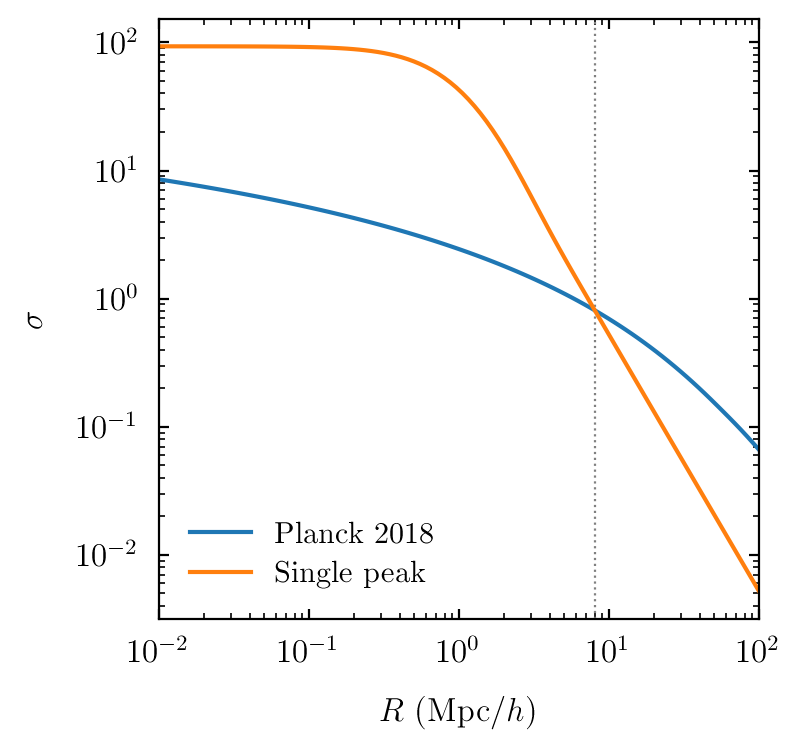

In [10]:
compare_colossus = False

plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$R\ ({\rm Mpc} / h)$')
plt.ylabel(r'$\sigma$')
plt.xlim(R_plot[0], R_plot[-1])
plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.gca().yaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.axvline(8.0, ls = ':', color = 'gray', lw = 0.8)

labels = []
for i in range(n_ps):
    pk_func, label = getPkFunc(i)
    labels.append(label)
    plt.plot(R_plot, sig[i], label = label)

# Compare to Colossus
if compare_colossus:
    sig_col = cosmo.sigma(R_plot)
    plt.plot(R_plot, sig_col, '--', label = r'$\mathrm{Planck\ (Colossus)}$')

plt.legend()
plt.show()

The characteristic scale is clearly imprinted on the variance in the single-peak spectrum. Smaller scales see a more or less fixed variance because it does not matter whether we probe scales that are small or very small compared to the characteristic fluctuation size. At larger scales, we simply average over larger and larger regions, which reduces the variance as a power law. What actually appears in the PS function is the slope of the variance.

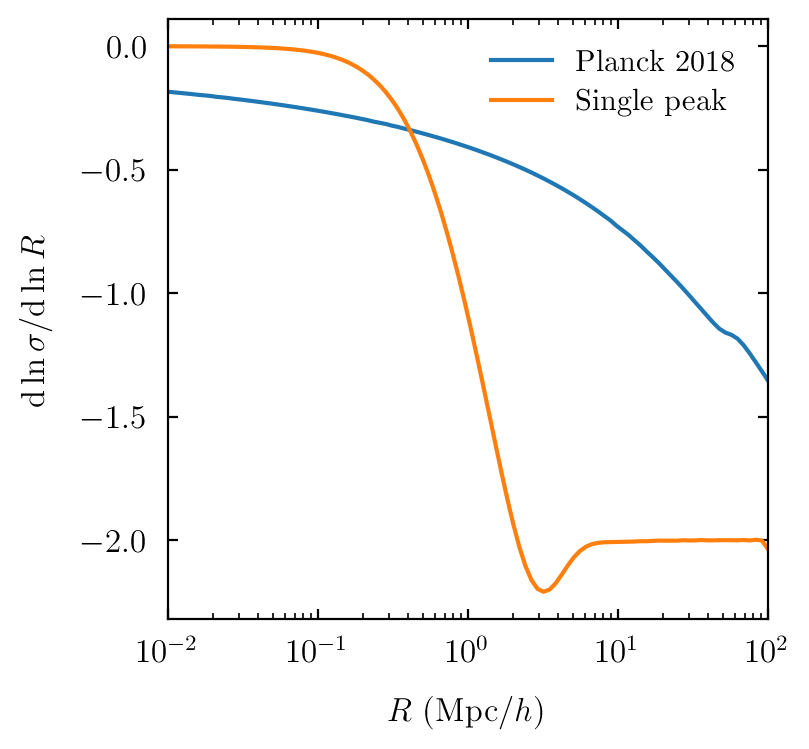

In [11]:
plt.figure(figsize = (4.0, 4.0))
plt.xscale('log')
plt.xlabel(r'$R\ ({\rm Mpc} / h)$')
plt.ylabel(r'${\rm d} \ln \sigma / {\rm d} \ln R$')
plt.xlim(R_plot[0], R_plot[-1])
plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

dsig_dr = np.zeros((n_ps, len(R_plot)), float)
interps_sig = []
interps_der = []

for i in range(n_ps):
    
    # Creating interpolating spline and its derivative spline, save in lists
    spl = scipy.interpolate.InterpolatedUnivariateSpline(log_R_plot, np.log10(sig[i]))
    interps_sig.append(spl)
    spl_der = spl.derivative()
    interps_der.append(spl_der)
    
    # Evaluate derivative; note that log10 and ln give the same derivative
    dsig_dr[i, :] = spl_der(log_R_plot)
    plt.plot(R_plot, dsig_dr[i], label = labels[i])

# Compare to Colossus
if compare_colossus:
    dsig_dr_col = cosmo.sigma(R_plot, derivative = True)
    plt.plot(R_plot, dsig_dr_col, '--', label = r'$\mathrm{Planck\ (Colossus)}$')

plt.legend()
plt.show()

The wiggles on the very right edge are numerical and don't appear when using Colossus, but we don't worry about them too much for this purpose. It looks like the slope at small radii, and thus halo masses, approaches zero, which found mean a mass function of zero. To clarify this point, we also plot the quantity that actually goes into the PS mass function, namely the absolute slope $|{\rm d} \ln \sigma / {\rm d} \ln M|$. We plot this quantity against mass, which we connect to $\sigma$ via the Lagrangian radius. We plot on a log scale to highlight the behavior at small $M$.

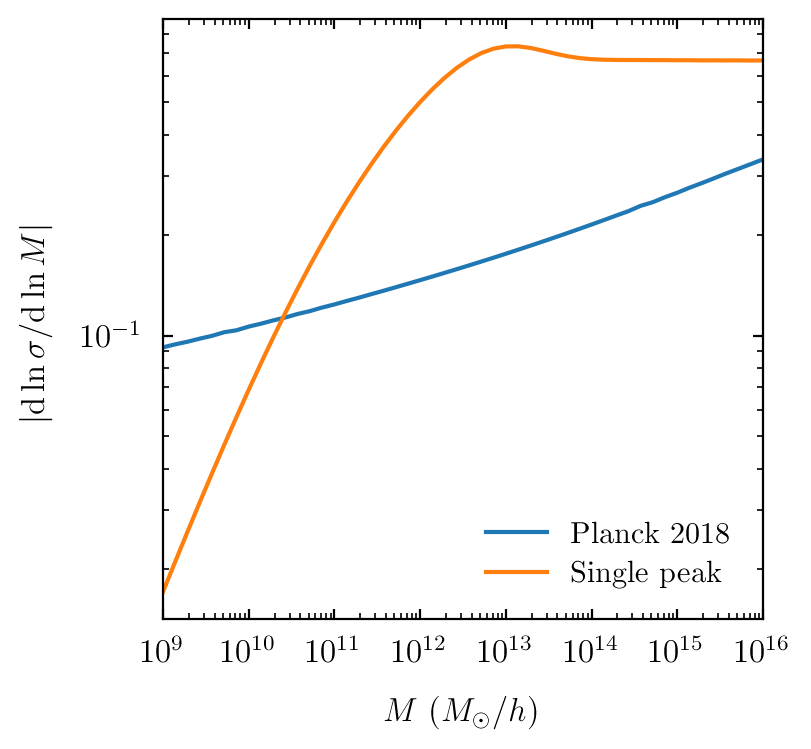

In [12]:
# Create Lagrangian radii from masses; note the unit conversion in density
rho_m_0 = cosmo.rho_m(0.0) * 1E9
M_plot = 10**np.linspace(9.0, 16.0, 50)
R_L = (3.0 * M_plot / (4.0 * np.pi * rho_m_0))**(1.0 / 3.0)

plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$M\ (M_\odot / h)$')
plt.ylabel(r'$|{\rm d} \ln \sigma / {\rm d} \ln M|$')
plt.xlim(M_plot[0], M_plot[-1])
plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i in range(n_ps):
    sig_M = 10**interps_sig[i](np.log10(R_L))
    dlnsig_dlnr = interps_der[i](np.log10(R_L))
    dlnsig_dlnm = np.abs(dlnsig_dlnr / 3.0)

    plt.plot(M_plot, dlnsig_dlnm, label = labels[i])

plt.legend()
plt.show()

The final ingredient is the universal PS multiplicity function. We first plot the peak height as a function of mass because it varies substantially between the models.

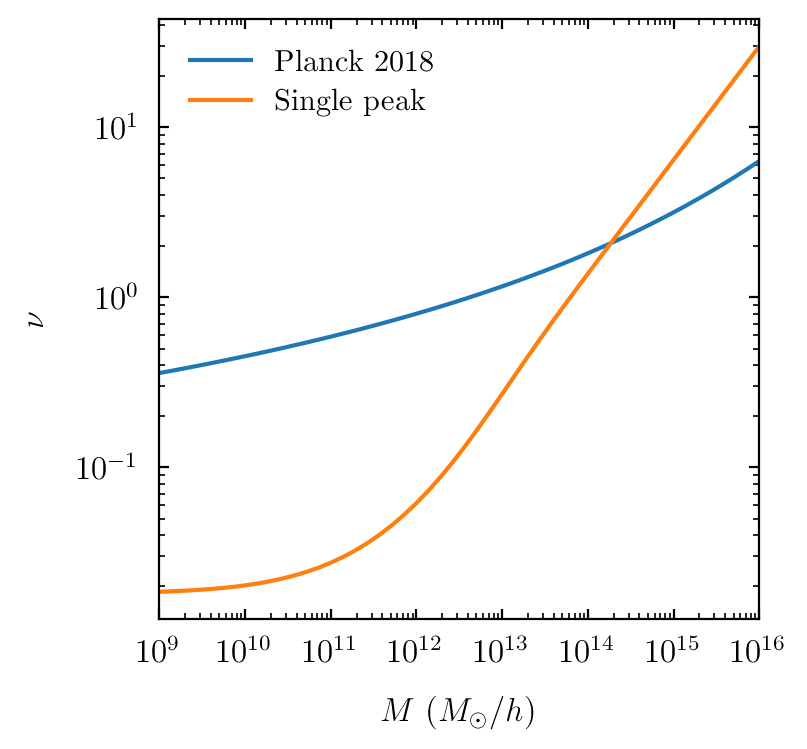

In [13]:
delta_c = 1.686

plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$M\ (M_\odot / h)$')
plt.ylabel(r'$\nu$')
plt.xlim(M_plot[0], M_plot[-1])
plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.gca().yaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i in range(n_ps):
    sig_M = 10**interps_sig[i](np.log10(R_L))
    nu = delta_c / sig_M
    plt.plot(M_plot, nu, label = labels[i])

plt.legend()
plt.show()

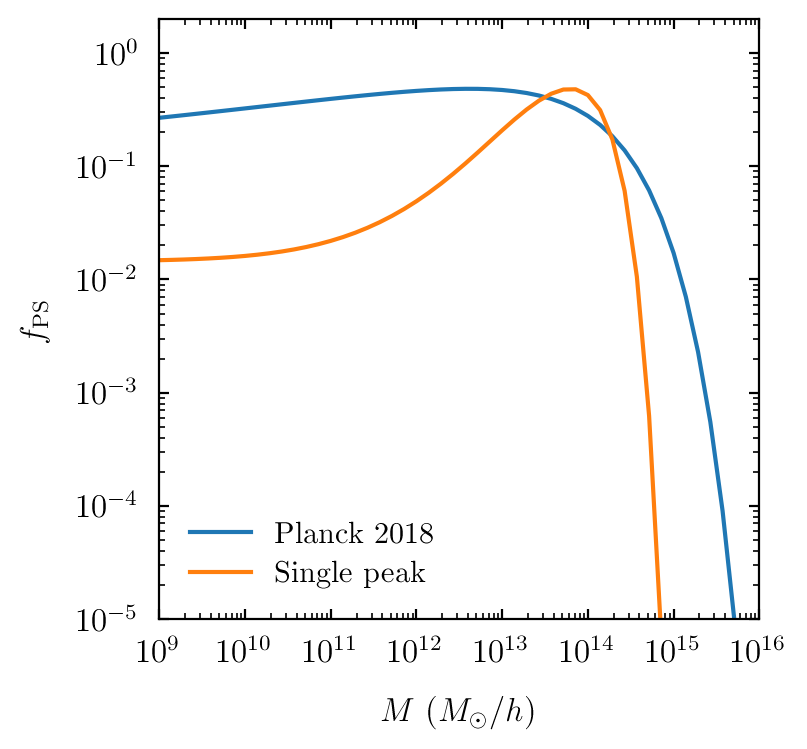

In [14]:
plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$M\ (M_\odot / h)$')
plt.ylabel(r'$f_{\rm PS}$')
plt.xlim(M_plot[0], M_plot[-1])
plt.ylim(1e-5, 2E0)
plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.gca().yaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i in range(n_ps):
    sig_M = 10**interps_sig[i](np.log10(R_L))
    nu = delta_c / sig_M
    f_ps = np.sqrt(2.0 / np.pi) * nu * np.exp(-nu**2 / 2.0)
    plt.plot(M_plot, f_ps, label = labels[i])
    
plt.legend()
plt.show()

We can now put it all together to compute our PS mass functions.

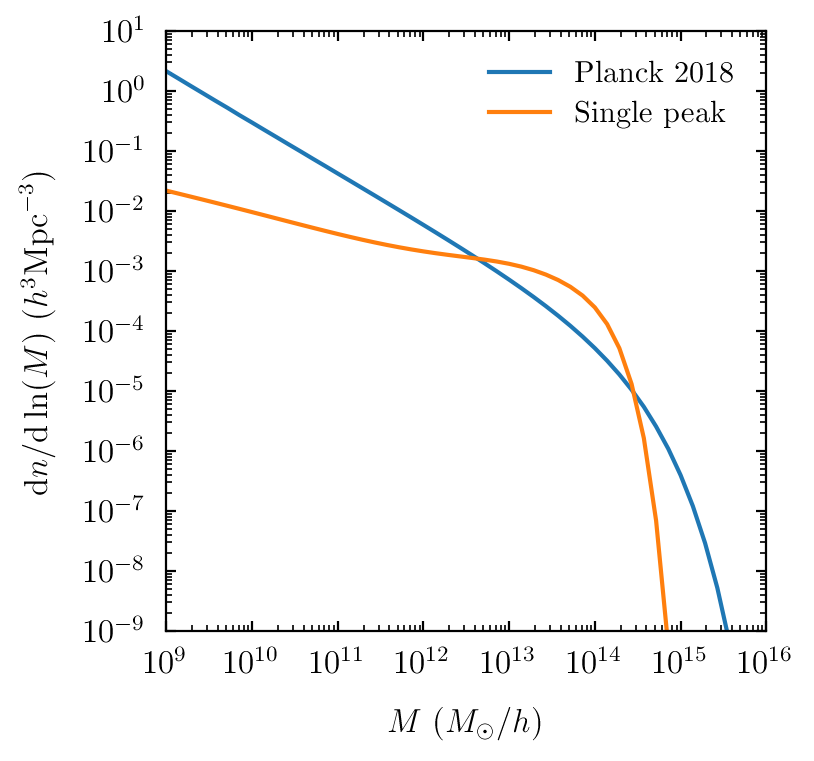

In [15]:
from colossus.lss import mass_function

z = 0.0

plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$M\ (M_\odot / h)$')
plt.ylabel(r'${\rm d}n / {\rm d} \ln(M)\ (h^3 {\rm Mpc}^{-3})$')
plt.xlim(M_plot[0], M_plot[-1])
plt.ylim(1e-9, 1E1)
plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.gca().yaxis.set_major_locator(LogLocator(numticks = 100))
plt.gca().yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i in range(n_ps):
    sig_M = 10**interps_sig[i](np.log10(R_L))
    dlnsig_dlnr = interps_der[i](np.log10(R_L))
    dlnsig_dlnm = np.abs(dlnsig_dlnr / 3.0)
    nu = delta_c / sig_M
    f_ps = np.sqrt(2.0 / np.pi) * nu * np.exp(-nu**2 / 2.0)
    mf = rho_m_0 / M_plot * dlnsig_dlnm * f_ps
    plt.plot(M_plot, mf, label = labels[i])

# Compare to Colossus
if compare_colossus:
    mf_col = mass_function.massFunction(M_plot, z, q_in = 'M', q_out = 'dndlnM', model = 'press74') 
    plt.plot(M_plot, mf_col, '--', label = r'$\mathrm{Planck\ (Colossus)}$')

plt.legend()
plt.show()

The characteristic scale in the power spectrum has imprinted itself as a characteristic halo mass scale of $M \sim 10^{14}\ M_\odot / h$, but the mass function rises towards lower halo masses.

#### Comparison to simulations

Let's check how well the PS mass function performs when compared to N-body simulations. We use the Erebos suite of simulations, which are documented in a number of papers, e.g. [Diemer & Kravtsov 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...799..108D/abstract). However, everything we need is contained in reduced merger tree files in the data directory. These files are excerpts from much larger merger tree files with the full information.

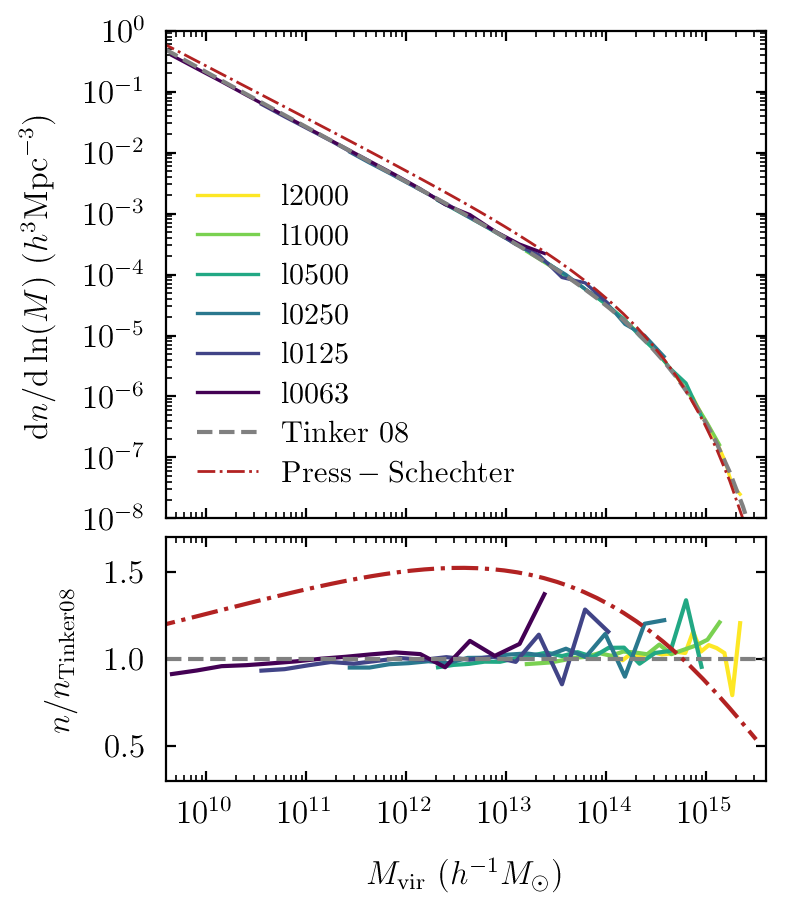

In [16]:
import h5py
from matplotlib.ticker import LogLocator

from colossus.lss import mass_function
from colossus.cosmology import cosmology

def getMassFunction(sim_name, z, min_n_ptl = 200, n_bins = 20, n_min_in_bin = 20):
    
    # Open file and load simulation info
    fn = cmn.data_dir + 'nbody/tree_%s.hdf5' % (sim_name)
    f = h5py.File(fn, 'r')
    snap_z = f['simulation'].attrs['snap_z']
    L_box = f['simulation'].attrs['box_size']
    m_ptl = f['simulation'].attrs['particle_mass']
    M_min = m_ptl * min_n_ptl
    V = L_box**3
    
    # Find closest snapshot
    snap_idx = np.argmin(np.abs(snap_z - z))
    
    # Load mass and subhalo status
    M = np.array(f['Mvir'][snap_idx, :])
    is_sub = np.array(f['is_subhalo'][snap_idx, :])
    f.close()
    
    # Cut out subhalos and halos below particle limit
    mask = np.logical_not(is_sub) & (M >= M_min)
    M = M[mask]

    # Compute mass function as dn / d ln(M)
    log_M = np.log(M)
    mf, bin_edges = np.histogram(log_M, bins = n_bins)
    bin_width = bin_edges[1:] - bin_edges[:-1]
   
    mask = (mf > n_min_in_bin)

    mf = np.array(mf, float) / bin_width / V
    bin_edges_log = np.log10(np.exp(bin_edges))
    bin_centers_log = 0.5 * (bin_edges_log[1:] + bin_edges_log[:-1])
    bin_centers = 10**bin_centers_log
    
    return mf[mask], bin_centers[mask]

cosmo = cosmology.setCosmology('bolshoi')
sim_names = ['l2000-bol', 'l1000-bol', 'l0500-bol', 'l0250-bol', 'l0125-bol', 'l0063-bol']
z = 0.0
cmap = plt.get_cmap('viridis_r')

# Prepare plot
fig, axs = plt.subplots(2, 1, height_ratios = [1.0, 0.5], figsize = (4.0, 5.0))
plt.subplots_adjust(hspace = 0.05)

plt.sca(axs[0])
plt.loglog()
plt.ylim(1E-8, 1E0)
axs[0].set_xticklabels([])
plt.ylabel(r'${\rm d}n / {\rm d} \ln(M)\ (h^3 {\rm Mpc}^{-3})$')
axs[0].yaxis.set_major_locator(LogLocator(numticks = 100))
axs[0].yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

plt.sca(axs[1])
plt.xscale('log')
plt.ylim(0.3, 1.7)
plt.xlabel(r'$M_{\rm vir}\ (h^{-1} M_\odot)$')
plt.ylabel(r'$n / n_{\rm Tinker08}$')

for ax in axs:
    plt.sca(ax)
    plt.xlim(4E9, 4E15)
    ax.xaxis.set_major_locator(LogLocator(numticks = 100))
    ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

# Plot analytical mass functions
comp_M_log = np.linspace(9.0, 15.5, 50)
comp_M = 10**comp_M_log
comp_mf = mass_function.massFunction(comp_M, z, q_in = 'M', q_out = 'dndlnM', model = 'tinker08', mdef = 'vir')
ps_mf = mass_function.massFunction(comp_M, z, q_in = 'M', q_out = 'dndlnM', model = 'press74')

# Add simulations
for i, sn in enumerate(sim_names):
    
    c = cmap(float(i) / (len(sim_names) - 1.0))
    
    plt.sca(axs[0])
    mf, bin_centers = getMassFunction(sn, z)
    plt.plot(bin_centers, mf, c = c, lw = 1.2, label = r'$\mathrm{%s}$' % sn[:-4])
    
    plt.sca(axs[1])
    comp_interp = 10**np.interp(np.log10(bin_centers), np.log10(comp_M), np.log10(comp_mf))
    plt.plot(bin_centers, mf / comp_interp, c = c)

# Add models
plt.sca(axs[0])
plt.plot(comp_M, comp_mf, '--', color = 'gray', label = r'$\mathrm{Tinker\ 08}$')
plt.plot(comp_M, ps_mf, '-.', color = 'firebrick', lw = 1.0, label = r'$\mathrm{Press-Schechter}$')

plt.sca(axs[1])
plt.axhline(1.0, ls = '--', color = 'gray')
plt.plot(comp_M, ps_mf / comp_mf, '-.', color = 'firebrick')

plt.sca(axs[0])
plt.legend()
plt.show()

### 4.3) Halo structure and its connection to formation history

Let's plot different models of the density profile using Colossus. We could also implement the formulae ourselves, but one nice thing that Colossus does is that it automatically normalizes the profile given a halo mass and concentration, rather than scale density and so on.

The profile models really only describe the inner part of the halo, $r < R_{\rm vir}$ or so. At larger radii, the profile is dominated by particles that are falling into the halo for the first time rather than already having orbited at least once. This contribution can be approximated by a power law in density. We plot the profiles both without and with this contribution. The former plot shows us the intrinsic behavior of the profile models at large radii, whereas the second plot paints a more realistic picture.

/Users/benedito/University/code/colossus_dev/colossus/halo/profile_base.py:709: RuntimeWarning: invalid value encountered in divide
  der = drho_dr * r / rho


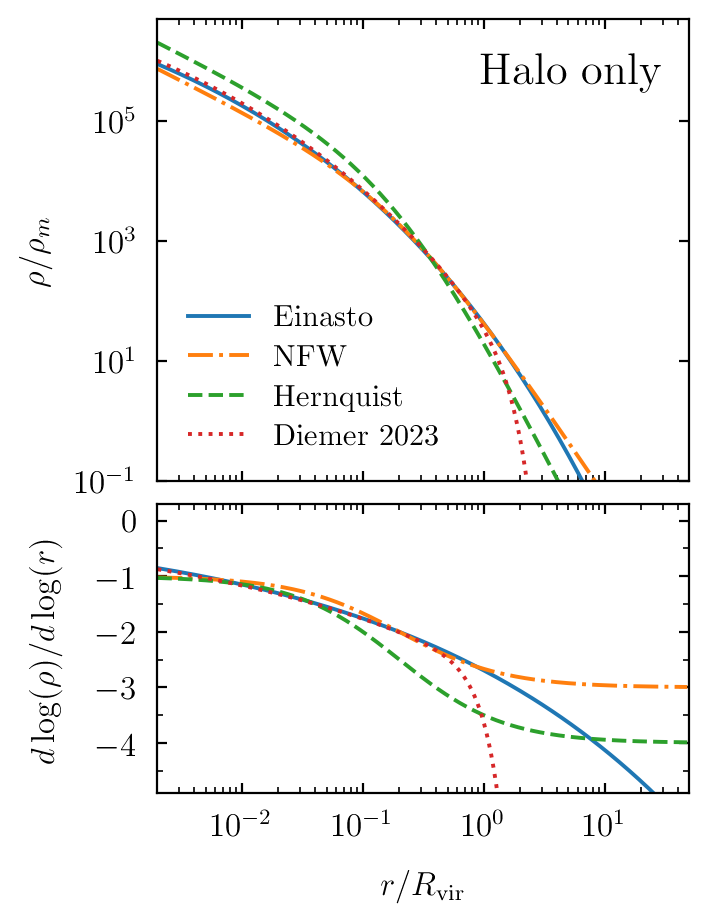

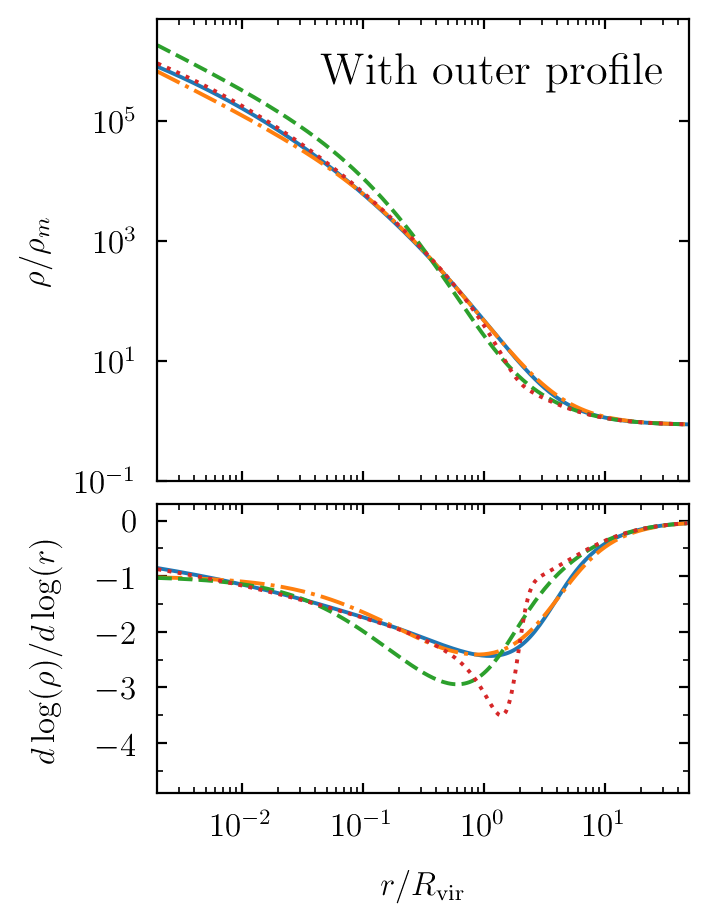

In [17]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, MultipleLocator

from colossus.halo import mass_so
from colossus.halo import profile_composite

prf_names = ['einasto']
prf_names.append('nfw')
prf_names.append('hernquist')
prf_names.append('diemer23')

# Halo parameters
M = 1E14
mdef = '200m'
z = 0.0
c = 5.0

# Plot twice, without and with an outer (infalling) profile
for j in range(2):
    
    if j == 0:
        outer_names = []
        biglabel = r'$\mathrm{Halo\ only}$'
    else:
        outer_names = ['infalling', 'mean']
        biglabel = r'$\mathrm{With\ outer\ profile}$'

    # Plot parameters
    prof_colors = cmn.color_cycle
    prof_ls = ['-', '-.', '--', ':', '-', '-']
    prof_lw = 1.4

    # Choose a set of radii
    cosmo = cmn.cosmo
    R = mass_so.M_to_R(M, z, mdef)
    rR_min = 2E-3
    rR_max = 5E1
    rR = 10**np.arange(np.log10(rR_min), np.log10(rR_max), 0.02)
    r = rR * R
    rho_m = cosmo.rho_m(z)

    ot_par = {}
    for i in range(len(outer_names)):
        if outer_names[i] == 'mean':
            ot_par.update(dict())
        elif outer_names[i] == 'cf':
            ot_par.update(dict(derive_bias_from = 'R200m'))
        elif outer_names[i] == 'pl':
            ot_par.update(dict(norm = defaults.HALO_PROFILE_DK14_PL_NORM, 
                    slope = defaults.HALO_PROFILE_DK14_PL_SLOPE, 
                    pivot = 'R200m', pivot_factor = 5.0))
        elif outer_names[i] == 'infalling':
            ot_par.update(dict(pl_delta_1 = 10.0, pl_s = 1.5))
        else:
            raise Exception('Unknown outer term, %s.' % (outer_names[i]))

    p = []
    labels = []
    for i in range(len(prf_names)):
        prof = profile_composite.compositeProfile(inner_name = prf_names[i], 
                        outer_names = outer_names, M = M, c = c, z = z, mdef = mdef, **ot_par)
        p.append(prof)
        if prf_names[i] == 'einasto':
            labels.append(r'$\mathrm{Einasto}$')
        elif prf_names[i] == 'hernquist':
            labels.append(r'$\mathrm{Hernquist}$')
        elif prf_names[i] == 'nfw':
            labels.append(r'$\mathrm{NFW}$')
        elif prf_names[i] == 'diemer23':
            labels.append(r'$\mathrm{Diemer\ 2023}$')
        else:
            raise Exception('Unknown inner name.')

    # Prepare plot
    fig = plt.figure(figsize = (3.5, 4.5))
    gs = gridspec.GridSpec(2, 1, height_ratios = [0.8, 0.5])
    plt.subplots_adjust(left = 0.2, right = 0.96, top = 0.98, bottom = 0.12, hspace = 0.06)
    p1 = fig.add_subplot(gs[0])	
    p2 = fig.add_subplot(gs[1])

    # Density panel
    plt.sca(p1)
    plt.loglog()
    plt.ylabel(r'$\rho / \rho_m$', labelpad = 8)
    p1.set_xticklabels([])
    plt.xlim(rR_min, rR_max)
    plt.ylim(1E-1, 5E6)
    for i in range(len(p)):
        rho = p[i].density(r)
        plt.plot(rR, rho / rho_m, ls = prof_ls[i], color = prof_colors[i], lw = prof_lw, label = labels[i])

    # Slope panel
    plt.sca(p2)
    plt.xscale('log')
    plt.xlim(rR_min, rR_max)
    plt.ylim(-4.9, 0.3)
    plt.xlabel(r'$r / R_{\rm vir}$')
    plt.ylabel(r'$d \log(\rho) / d \log(r)$', labelpad = 12)
    p2.yaxis.set_major_locator(MultipleLocator(1.0))
    p2.yaxis.set_minor_locator(MultipleLocator(0.5))
    for i in range(len(p)):
        slope = p[i].densityDerivativeLog(r)
        plt.plot(rR, slope, ls = prof_ls[i], color = prof_colors[i], lw = prof_lw, label = labels[i])

    # Finalize plot
    plt.sca(p1)
    if j == 0:
        plt.legend(loc = 3)
    plt.text(0.95, 0.86, biglabel, transform = plt.gca().transAxes, fontsize = 16, ha = 'right')
    plt.show()

#### Circular velocity revisited

Each density profile model also corresponds to a potential. This reminds us of our plot of the circular velocity in the MW, where we found a poor match to the stellar components. We can now also include the halo potential. We use an NFW profile with the canonical mass of $10^{12}\ M_\odot$ and the median concentration of such halos calibrated by a concentration-mass relation.

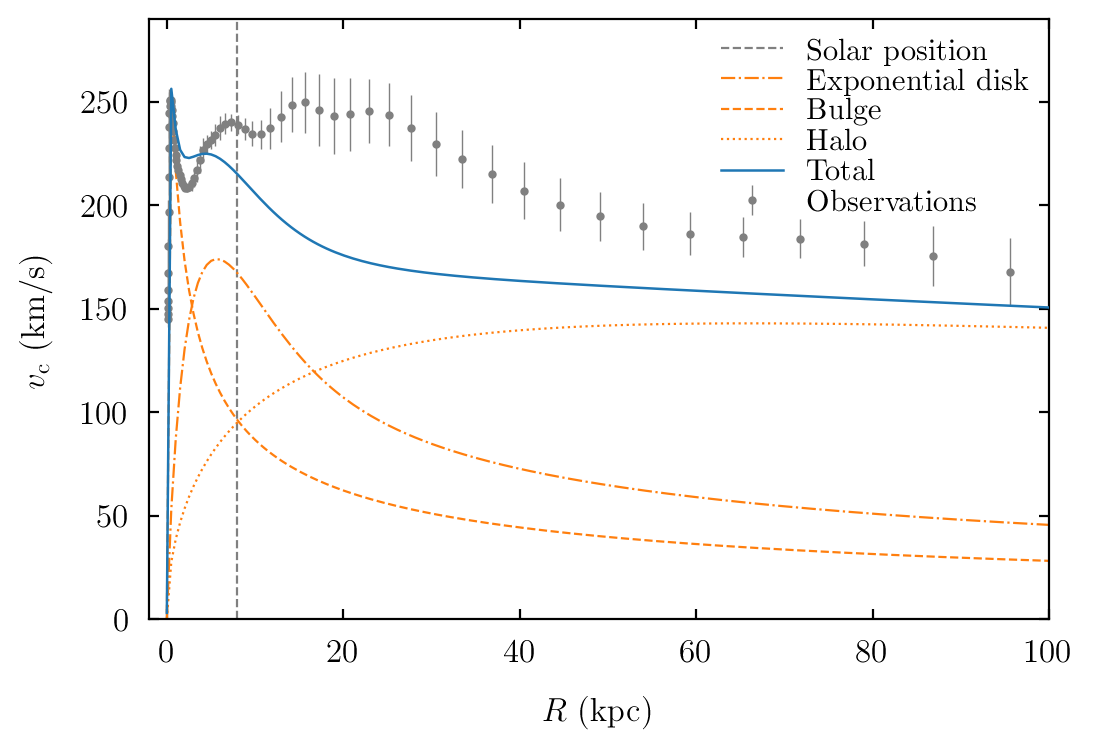

In [18]:
import scipy.special
from colossus.utils import constants
from colossus.halo import profile_hernquist
from colossus.halo import mass_so
from colossus.halo import concentration

from routines import obs_utils

# Disk data from Licquia & Newman 2016, bulge data from Ninkovic 2017
M_disk = 4.8E10
R_d = obs_utils.Rd_MW
M_bulge = 1.85E10
R_bulge = 0.3
M_halo = 1E12

# Load rotation curve data
d = np.loadtxt(cmn.data_dir + 'milky_way/rotation_curve_sofue_2020.txt', unpack = True)

# Calculate circular velocity due to exponential disk (Binney & Tremaine equation 2.165)
# Note that G in Colossus has units of kpc km^2 / Msun s^2
Sigma_0 = M_disk / (2.0 * np.pi * R_d**2)
R = np.linspace(1E-5, 100.0, 200)
y = R / 2.0 / R_d
I_0 = scipy.special.iv(0, y)
I_1 = scipy.special.iv(1, y)
K_0 = scipy.special.kn(0, y)
K_1 = scipy.special.kn(1, y)
V_disk = np.sqrt(4.0 * np.pi * constants.G * Sigma_0 * R_d * y**2 * (I_0 * K_0 - I_1 * K_1))

# Bulge. Create a Hernquist profile and normalize it to have the desired total mass
h = cmn.cosmo.h
prf = profile_hernquist.HernquistProfile(rhos = 1.0, rs = R_bulge * h)
M_norm = prf.enclosedMass(1000.0) / h
prf = profile_hernquist.HernquistProfile(rhos = M_bulge / M_norm, rs = R_bulge * h)
V_bulge = prf.circularVelocity(R * h)

# Halo
c = concentration.concentration(M_halo, 'vir', 0.0)
R_halo = mass_so.M_to_R(M_halo, 0.0, 'vir') / cmn.cosmo.h
rs = R_halo / c
M_Rvir = 4.0 * np.pi * rs**3 * (np.log(1.0 + c) - c / (1.0 + c))
rho_s = M_halo / M_Rvir
r_rs = R / rs
M_R = 4.0 * np.pi * rs**3 * rho_s * (np.log(1.0 + r_rs) - r_rs / (1.0 + r_rs))
V_halo = np.sqrt(constants.G * M_R / R)

# Compute total circular velocity curve
V_tot = np.sqrt(V_bulge**2 + V_disk**2 + V_halo**2)

# Plot
plt.figure(figsize = (6.0, 4.0))
plt.xlabel(r'$R\ ({\rm kpc})$')
plt.ylabel(r'$v_{\rm c}\ ({\rm km} / {\rm s})$')
plt.axvline(8.0, ls = '--', color = 'gray', lw = 0.8, label = r'$\mathrm{Solar\ position}$')
plt.errorbar(d[0], d[1], d[2], fmt = 'o', ms = 2.0, color = 'gray', lw = 0.5, label = r'$\mathrm{Observations}$')

plt.plot(R, V_disk, '-.', label = r'$\mathrm{Exponential\ disk}$', lw = 0.8, color = cmn.color_cycle[1])
plt.plot(R, V_bulge, '--', label = r'$\mathrm{Bulge}$', lw = 0.8, color = cmn.color_cycle[1])
plt.plot(R, V_halo, ':', label = r'$\mathrm{Halo}$', lw = 0.8, color = cmn.color_cycle[1])
plt.plot(R, V_tot, '-', label = r'$\mathrm{Total}$', lw = 0.9, zorder = 100)

plt.xlim(-2.0, 100.0)
plt.ylim(0.0, 290.0)
plt.legend(labelspacing = 0.1, borderpad = 0.1)
plt.show()

The fit is obviously much better than with stars only, but at intermediate radii still seems to underestimate the enclosed mass.